## Load library


In [1]:
import torch
import os
from PIL import Image,ImageEnhance, ImageFilter
import torchvision.transforms.functional as F
import torch.nn as nn
from torchvision import models, transforms as T
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim

# Set Paths

In [2]:
train_data_path = os.path.join("/kaggle/input",'aiunict2024-challenge-2','train')
test_data_path = os.path.join("/kaggle/input",'aiunict2024-challenge-2','test')

bbox_train_path = os.path.join("/kaggle/input","aiunict2024-challenge-2","train.csv")
bbox_test_path = os.path.join(os.getcwd(),"test.csv")

model_path = os.path.join(os.getcwd(), "vgg16_classifier.pt")
result_path = os.path.join(os.getcwd(), "submission.csv")

# Discussion of the Idea:
Since the background is the primary challenge in this image classification task and we don't have bounding boxes for the test set, we need a model that can detect the bounding box for a given image. To achieve this, we'll use a custom VGG16 model where we modify the loss function and the output layer. Instead of classifying images, our model will predict four coordinates representing the bounding box. This shifts our problem from classification to regression, so we will use Mean Squared Error (MSE) loss instead of the typical cross-entropy loss.

## Design a Cusotm VG16 for Bounded Box Detection

In [3]:
class VGG16_BBox(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG16_BBox, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        self.vgg.classifier = nn.Sequential()  # Remove original fully connected layers (classifier)
        self.flatten = nn.Flatten() # nn.Flatten() converte 3D output from conv in a vettore 1D
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, num_classes)
        # Dropout
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.vgg.features(x) # inputs go through convs --> f.maps extractions
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  #'output is a tensor of dim [batch_size, 4]
        return x


## Create Custom Datasets

In [4]:
class CustomDataset(Dataset):
    def __init__(self, bbox_dataframe, data_folder):
        self.bbox_dataframe = bbox_dataframe # csv: class+name,bbox 
        self.data_folder = data_folder #cartella where save images
        

    def __len__(self):
        return len(self.bbox_dataframe)

    def __getitem__(self, idx):
        row = self.bbox_dataframe.iloc[idx]
        image_path = row['image'] #select the ith element (es:00/00_000.png)
        image = Image.open(os.path.join(self.data_folder, image_path)) #open image tha ks this path: input/aiunict2024-challenge-2/train/ + (es:00/00_000.png)
        width, height = image.size 
        startX,startY,endX,endY= row['x1'], row['y1'], row['x2'], row['y2'] #get coordinates
        new_startX = int(startX/width*224) #get new bbox for image (224,224)
        new_startY = int(startY/height*224)
        new_endX = int(endX/width*224)
        new_endY = int(endY/height*224)
        bbox_rescaled = torch.tensor([new_startX, new_startY, new_endX, new_endY])
        resized_image = image.resize((224, 224))
        tensor_resized_image = T.ToTensor()(resized_image)
            
        return {'resize_image':tensor_resized_image, 'bbox':bbox_rescaled}


bbox_train_csv = pd.read_csv(bbox_train_path)


train_dataset = CustomDataset(bbox_dataframe=bbox_train_csv, data_folder=train_data_path)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers= 4)

### visualization


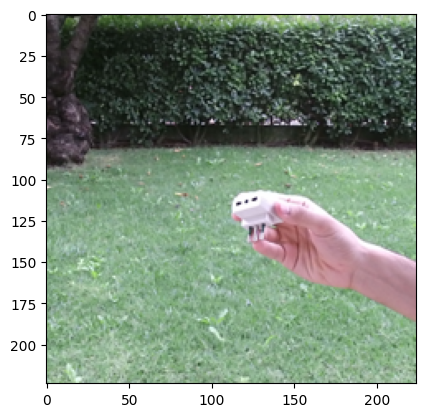

In [5]:
# Get a batch
data_iter = iter(train_loader)
batch = next(data_iter)

# Visualize the last image of the first batch
last_transformed_image = batch['resize_image'][-1]
last_transformed_image_pil = T.ToPILImage()(last_transformed_image)
plt.imshow(last_transformed_image_pil)
plt.show()

In [6]:
class CustomTestset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, file_name) for file_name in os.listdir(os.path.join(root_dir))]


    def __len__(self):
        return len(self.image_paths) 

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        resized_image = image.resize((224, 224))
        tensor_resized_image = T.ToTensor()(resized_image)
    
        return {'resize_image':tensor_resized_image, 'image_name':image_path.split('/')[-1]}


test_dataset = CustomTestset(root_dir=test_data_path)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### visualization

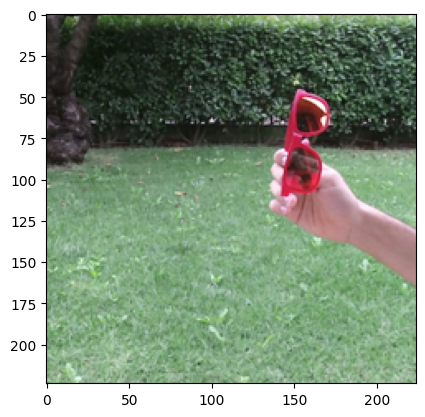

In [7]:
# Get a batch
data_iter = iter(test_loader)

batch = next(data_iter)

# Visualize the last image of the first batch
last_transformed_image = batch['resize_image'][-1]
last_transformed_image_pil = T.ToPILImage()(last_transformed_image)
plt.imshow(last_transformed_image_pil)
plt.show()

## Train our Custom VGG16_BBox

In [8]:
# Initialize the model
model = VGG16_BBox(num_classes=4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

lr = 2e-5
epochs = 80
batch_size= 64

# Define the loss function and optimizer
criterion = nn.MSELoss()  #Regression Problem
optimizer = optim.Adam(model.parameters(), lr=lr)


def train_custom_vgg16_bbox_model(model, criterion, optimizer, dataloaders, num_epochs):
    best_model_wts = model.state_dict()
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 50)

        running_loss = 0.0

        for batch in dataloaders: #label is corrispondent bbox
            inputs = batch['resize_image'].to(device)
            labels = batch['bbox'].to(device, dtype=torch.float32)
           

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloaders)

        print(f'Loss: {epoch_loss:.4f}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict()

    print(f'Best Loss: {best_loss:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_det = train_custom_vgg16_bbox_model(model, criterion, optimizer, train_loader, num_epochs=epochs)
# Save the trained model
torch.save(model_det.state_dict(), model_path)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 154MB/s] 


Epoch 0/79
--------------------------------------------------
Loss: 15872.5959
Epoch 1/79
--------------------------------------------------
Loss: 4324.0784
Epoch 2/79
--------------------------------------------------
Loss: 1032.2791
Epoch 3/79
--------------------------------------------------
Loss: 505.5168
Epoch 4/79
--------------------------------------------------
Loss: 278.5503
Epoch 5/79
--------------------------------------------------
Loss: 199.3118
Epoch 6/79
--------------------------------------------------
Loss: 161.0932
Epoch 7/79
--------------------------------------------------
Loss: 132.5321
Epoch 8/79
--------------------------------------------------
Loss: 112.5298
Epoch 9/79
--------------------------------------------------
Loss: 101.5668
Epoch 10/79
--------------------------------------------------
Loss: 89.5143
Epoch 11/79
--------------------------------------------------
Loss: 83.3138
Epoch 12/79
--------------------------------------------------
Loss: 72.

## Make prediction of the trained model on test set in order to get BBOX for test set images

In [9]:
img_name_list= []
x1_list = []
y1_list = []
x2_list = []
y2_list = []

# Make predictions on the test set
model.eval()
with torch.no_grad():
    for batch in test_loader:
        resize_image= batch['resize_image'].to(device)
        img_name = batch['image_name'][0]
        outputs = model(resize_image)
        startX,startY,endX,endY=outputs.tolist()[0]
        img_name_list.append(img_name)
        x1_list.append(startX)
        y1_list.append(startY)
        x2_list.append(endX)
        y2_list.append(endY)

bbox_test_csv = pd.DataFrame({'image':img_name_list,'x1':x1_list,'y1':y1_list,'x2':x2_list,'y2':y2_list})
bbox_test_csv.to_csv(bbox_test_path,index=False)

## Now let's train a VGG16 from scratch in order to solve our classification problem

### Deafult Architecture

In [10]:
class VGG16(nn.Module):
    def __init__(self, num_classes=8):
        super(VGG16, self).__init__()
        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 4
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 5
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.fc1 = nn.Linear(512*7*7,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
    
        return x

### Transformation Pipeline

In [11]:
def enhance_image(img):
    # Aggiustamento della nitidezza
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # A factor of 1.0 means no change, less than 1.0 will reduce brightness, and more than 1.0 will increase brightness
    
    # Aggiustamento del contrasto
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(1.5)  # A factor of 1.0 means no change, less than 1.0 will reduce contast, and more than 1.0 will increase contrast
    
    # Application of detail filter --> emphasize the differences between adjacent pixels
    img = img.filter(ImageFilter.DETAIL)
    
    return img

train_data_transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((224, 224)),
    T.Lambda(lambda img: enhance_image(img)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=20),
    T.ToTensor(),
])

test_data_transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((224, 224)),
    T.Lambda(lambda img: enhance_image(img)),
    T.ToTensor(),
])

## Custom Dataset for Training and for Validation


In [12]:
class CustomDataset(Dataset):
    def __init__(self, bbox_dataframe, data_folder, transform=None): 
        self.bbox_dataframe = bbox_dataframe 
        self.data_folder = data_folder 
        self.transform = transform

    def __len__(self):
        return len(self.bbox_dataframe) 

    def __getitem__(self, idx):
        row = self.bbox_dataframe.iloc[idx] 
        label = row['class']
        image_path = row['image']
        image = Image.open(os.path.join(self.data_folder, image_path)) #exact path: input/aiunict2024-challenge-2/train/ + (es:00/00_000.png)
        width, height = image.size
        startX,startY,endX,endY= row['x1'], row['y1'], row['x2'], row['y2'] 
        new_startX = int(startX/width*224) 
        new_startY = int(startY/height*224)
        new_endX = int(endX/width*224)
        new_endY = int(endY/height*224)
        resized_image = image.resize((224, 224))
        cropped_image =  resized_image.crop((new_startX, new_startY, new_endX, new_endY))
        if self.transform:
            transformed_img = self.transform(cropped_image)

        return {'input':transformed_img, 'label':label}
    

# Split the data into training and validation sets
train_df, val_df = train_test_split(bbox_train_csv, test_size=0.1, random_state=42, stratify=bbox_train_csv['class'])

# Create the training and validation datasets
train_dataset = CustomDataset(bbox_dataframe=train_df, data_folder=train_data_path, transform=train_data_transform)
val_dataset = CustomDataset(bbox_dataframe=val_df, data_folder=train_data_path, transform=train_data_transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)

### visualization on training set

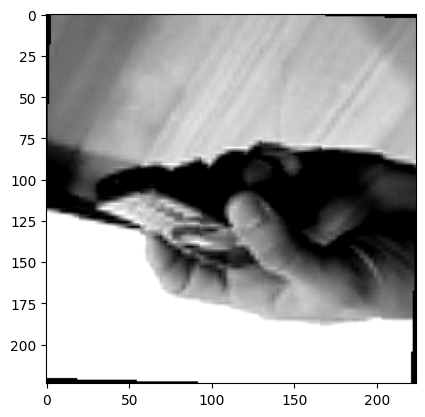

In [15]:
# Get a batch of image
data_iter = iter(train_loader)
batch = next(data_iter)

# Visualize the last image of the first batch
last_transformed_image = batch['input'][-1]
last_transformed_image_pil = T.ToPILImage()(last_transformed_image)
plt.imshow(last_transformed_image_pil)
plt.show()

### visualization on validation set

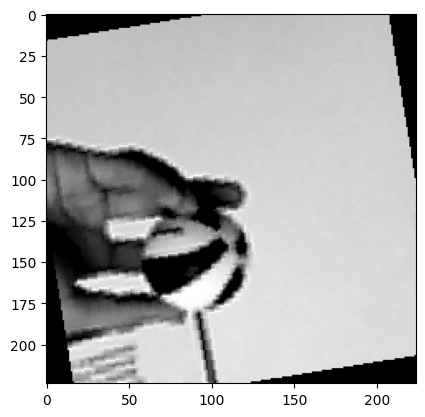

In [16]:
# Get a batch of image
data_iter = iter(val_loader)
batch = next(data_iter)

# Visualize the last image of the first batch
last_transformed_image = batch['input'][-1]
last_transformed_image_pil = T.ToPILImage()(last_transformed_image)
plt.imshow(last_transformed_image_pil)
plt.show()

In [17]:
class CustomTestDataset(Dataset):
    def __init__(self, bbox_dataframe, data_folder, transform=None): 
        self.bbox_dataframe = bbox_dataframe 
        self.data_folder = data_folder 
        self.transform = transform 

    def __len__(self):
        return len(self.bbox_dataframe) 

    def __getitem__(self, idx):
        row = self.bbox_dataframe.iloc[idx] 
        image_path = row['image'] 
        image = Image.open(os.path.join(self.data_folder, image_path)) #exact path: input/aiunict2024-challenge-2/train/ + (es:00/00_000.png)
        startX,startY,endX,endY= row['x1'], row['y1'], row['x2'], row['y2'] 

        #remember that in the test set bboxes were generated from the network considering image 224,224.
        #so there is no need to scale them, just resize the image from 350 to 224.

        resized_image = image.resize((224, 224))
        cropped_image =  resized_image.crop((startX, startY, endX, endY))
        if self.transform:
            transformed_img = self.transform(cropped_image)

        return {'input':transformed_img,'image_name':image_path.split('/')[-1]}
    
test_dataset = CustomTestDataset(bbox_dataframe=bbox_test_csv, data_folder=test_data_path, transform=test_data_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) 


### visualizzazion on test set

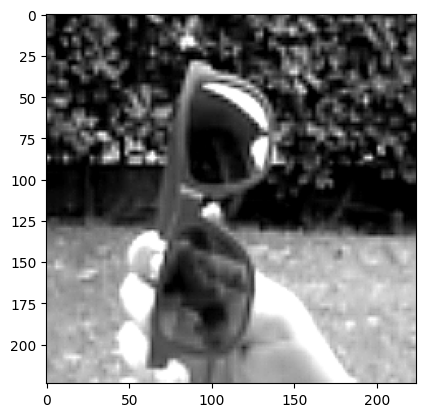

In [18]:
# Get a batch of image
data_iter = iter(test_loader)
batch = next(data_iter)

# Visualize the last image of the first batch
last_transformed_image = batch['input'][-1]
last_transformed_image_pil = T.ToPILImage()(last_transformed_image)
plt.imshow(last_transformed_image_pil)
plt.show()

### Training 

In [19]:
lr = 2e-5
epochs = 100
batch_size = 32

# Initialize the model
model = VGG16(num_classes=8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)


def train_vgg16_model_classifier(model, criterion, optimizer, dataloaders, num_epochs=epochs):
    
    best_model_wts = model.state_dict()
    best_loss = {"train": float('inf'), "val": float('inf')} 

    # Initialize history
    history_loss = {"train": [], "val": []}
    history_accuracy = {"train": [], "val": []}
    # Process each epoch
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 50)

        # Initialize epoch variables
        sum_loss = {"train": 0, "val": 0}
        correct_preds = {"train": 0, "val": 0}  
        total_samples = {"train": 0, "val": 0}  
        
        # Process each split
        for split in ["train", "val"]:
            if split == "train":
                model.train()
            else:
                model.eval()

            # Process each batch
            for batch in dataloaders[split]:
                inputs = batch['input'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                sum_loss[split] += loss.item() #batch loss
                
               
                if split == "train":
                    # Compute gradients
                    loss.backward()
                    # Optimize
                    optimizer.step()
                
                
                preds = torch.argmax(outputs, 1)
                
                # Compute batch accuracy
                correct_preds[split] += (preds == labels).sum().item()
                total_samples[split] += inputs.size(0)      


        # Compute epoch loss/accuracy
        epoch_loss = {split: sum_loss[split] / len(dataloaders[split]) for split in ["train", "val"]} #len(dataloaders[split]) gives you the number of batches in that DataLoader.
        epoch_accuracy = {split: correct_preds[split] / total_samples[split] for split in ["train", "val"]}

        
        # Update history
        for split in ["train", "val"]:
            history_loss[split].append(epoch_loss[split])
            history_accuracy[split].append(epoch_accuracy[split])

        if epoch_loss['train'] < best_loss['train']:  # Compare train loss with best train loss
            best_loss = epoch_loss
            best_model_wts = model.state_dict()

        print(f"Train Loss: {epoch_loss['train']:.4f}, Train Acc: {epoch_accuracy['train']:.4f}")
        print(f"Val Loss: {epoch_loss['val']:.4f}, Val Acc: {epoch_accuracy['val']:.4f}")
        
        model.load_state_dict(best_model_wts)
    
    # Plot and saving loss
    plt.figure(figsize=(10, 6))  
    plt.title("Loss")
    for split in ["train", "val"]:
        plt.plot(history_loss[split], label=split)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(os.getcwd(),"loss_plot.png"), dpi=300, bbox_inches="tight")  #
    plt.close()  

    # Plot and saving accuracy
    plt.figure(figsize=(10, 6))
    plt.title("Accuracy")
    for split in ["train", "val"]:
        plt.plot(history_accuracy[split], label=split)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(os.getcwd(),"accuracy_plot.png"), dpi=300, bbox_inches="tight")
    plt.close()
    
    return model




dataloaders = {
    'train': train_loader,
    'val': val_loader
}
# Train the model
model_cl = train_vgg16_model_classifier(model, criterion, optimizer, dataloaders, num_epochs=epochs)

# Save the trained model
torch.save(model_cl.state_dict(), model_path)

Epoch 0/99
--------------------------------------------------
Train Loss: 2.0802, Train Acc: 0.1132
Val Loss: 2.0795, Val Acc: 0.1250
Epoch 1/99
--------------------------------------------------
Train Loss: 2.0798, Train Acc: 0.1181
Val Loss: 2.0795, Val Acc: 0.1250
Epoch 2/99
--------------------------------------------------
Train Loss: 2.0796, Train Acc: 0.1257
Val Loss: 2.0795, Val Acc: 0.1250
Epoch 3/99
--------------------------------------------------
Train Loss: 2.0795, Train Acc: 0.1215
Val Loss: 2.0795, Val Acc: 0.1250
Epoch 4/99
--------------------------------------------------
Train Loss: 2.0797, Train Acc: 0.1153
Val Loss: 2.0795, Val Acc: 0.1250
Epoch 5/99
--------------------------------------------------
Train Loss: 2.0796, Train Acc: 0.1257
Val Loss: 2.0795, Val Acc: 0.1250
Epoch 6/99
--------------------------------------------------
Train Loss: 2.0796, Train Acc: 0.1264
Val Loss: 2.0795, Val Acc: 0.1250
Epoch 7/99
--------------------------------------------------


### Evaluate on Test

In [20]:
img_name_list = []
predicted_class_list = []

with torch.no_grad():
    for batch in test_loader:
        input = batch['input'].to(device)
        img_name = batch['image_name'][0]
        outputs = model(input)
        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1)
        # Get the predicted class
        _, predicted_class = torch.max(probabilities, 1)

        print(f'Image: {img_name}, Predicted Class: {predicted_class.item()}')
        img_name_list.append(img_name)
        predicted_class_list.append(predicted_class.item())



Image: 623.jpg, Predicted Class: 4
Image: 764.jpg, Predicted Class: 2
Image: 771.jpg, Predicted Class: 0
Image: 208.jpg, Predicted Class: 7
Image: 029.jpg, Predicted Class: 6
Image: 473.jpg, Predicted Class: 0
Image: 014.jpg, Predicted Class: 0
Image: 333.jpg, Predicted Class: 0
Image: 537.jpg, Predicted Class: 4
Image: 369.jpg, Predicted Class: 0
Image: 654.jpg, Predicted Class: 6
Image: 275.jpg, Predicted Class: 0
Image: 785.jpg, Predicted Class: 0
Image: 212.jpg, Predicted Class: 2
Image: 239.jpg, Predicted Class: 0
Image: 792.jpg, Predicted Class: 7
Image: 150.jpg, Predicted Class: 3
Image: 109.jpg, Predicted Class: 3
Image: 034.jpg, Predicted Class: 5
Image: 149.jpg, Predicted Class: 2
Image: 187.jpg, Predicted Class: 0
Image: 521.jpg, Predicted Class: 0
Image: 436.jpg, Predicted Class: 7
Image: 539.jpg, Predicted Class: 0
Image: 355.jpg, Predicted Class: 0
Image: 516.jpg, Predicted Class: 2
Image: 708.jpg, Predicted Class: 3
Image: 474.jpg, Predicted Class: 3
Image: 501.jpg, Pred

### Create the submission

In [21]:
submission = pd.DataFrame({'image':img_name_list,'class':predicted_class_list})
submission.to_csv(result_path,index=False)